In [40]:
import os
import pyspark 
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sb
import matplotlib.pyplot as plt
from pyspark.sql.functions import col ,round
from utils import preprocces_text



In [2]:
from dotenv import load_dotenv
load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
os.environ['PYSPARK_PYTHON'] = os.getenv("PYSPARK_PYTHON")


In [3]:
spark = SparkSession.builder \
    .master("local[8]") \
    .appName("Airbnb Listings") \
    .config("spark.network.timeout", "1800000000s") \
    .config("spark.executor.heartbeatInterval", "600s") \
    .config("spark.shuffle.io.connectionTimeout", "3600s") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile",key_filepath  ) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .getOrCreate()       


    

In [55]:

# Read data from GCS
df = spark.read.parquet("gs://airbnb-listings-421017-bucket/airbnb_listings.parquet")


In [ ]:
top_100_summary = df.select("summary").filter(col("summary") != "N/A").sort(col("price").desc()).limit(100).collect()

least_100_summary = df.select("summary").filter(col("summary") != "N/A").sort(col("price").asc()).limit(100).collect()

In [6]:
summary_preprocessed = [preprocces_text(row.summary) for row in top_100_summary]
summary_preprocessed = ' '.join([' '.join(row) for row in summary_preprocessed])

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 500, height = 400, background_color="white").generate(summary_preprocessed)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [8]:
least100_summary_preprocessed = [preprocces_text(row.summary) for row in least_100_summary]
least100_summary_preprocessed = ' '.join([' '.join(row) for row in least100_summary_preprocessed])

In [9]:
print(least100_summary_preprocessed)

enjoy comfy pull-out bed capitol hill neighborhood block away seattle trendiest restaurant bar nightlife -5 minute walk heart capitol hill -15 – minute walk minute drive downtown seattle low budget traveler need place sleep shower toilet found listing providing two person tent sleeping pad sleeping bag also three person tent available min night stay single bed conner laundry room clean quiet easiest commute town seatac airport place take min via link light rail place downtown seattle min ride 3min foot station airbnb location ... walking distance downtown international district cap hill pike place market restaurant bar club seattle u. within busing distance uw space needle listing bottom bunk minute walk broadway heart capitol hill downtown seattle despite living bar noise level night small bus ride away u-district airbnb location ... walking distance downtown international district cap hill pike place market restaurant bar club seattle u. within busing distance uw space needle listing

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 500, height = 400, background_color="white").generate(least100_summary_preprocessed)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Analyzing if review sentiment has any relation with price


In [46]:
# read csv and infere datatypes 
 
reviews_df = pd.read_csv("reviews.csv", sep=","  , infer_datetime_format=True, parse_dates=["date"]) 



C:\Users\Mohamed Hussein\AppData\Local\Temp\ipykernel_21752\1157742635.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reviews_df = pd.read_csv("reviews.csv", sep=","  , infer_datetime_format=True, parse_dates=["date"])


In [47]:
# drop na values 
reviews_df[reviews_df['comments'].isnull()].head()

reviews_df = reviews_df.dropna()
# print reviewer_name that are null 

reviews_df[reviews_df['comments'].isnull()].head()


,listing_id,id,date,reviewer_id,reviewer_name,comments


In [48]:
from langdetect import detect
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def detect_language(text):
    try:
        return detect(str(text))
    except:
        return None

# apply detect_language function to the reviews_df comments column
reviews_df["language"] = reviews_df["comments"].apply(detect_language)


In [49]:
# filter only english comments
reviews_df = reviews_df[reviews_df["language"] == "en"]


In [50]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import FloatType, StructType, StructField

sentiment_analysis = SentimentIntensityAnalyzer()

reviews_df['polarity_scores'] = reviews_df['comments'].apply(lambda x: sentiment_analysis.polarity_scores(x))





In [51]:
reviews_df['neg'] = reviews_df['polarity_scores'].apply(lambda x: x['neg'])
reviews_df['neu'] = reviews_df['polarity_scores'].apply(lambda x: x['neu'])
reviews_df['pos'] = reviews_df['polarity_scores'].apply(lambda x: x['pos'])
reviews_df['compound'] = reviews_df['polarity_scores'].apply(lambda x: x['compound'])


In [52]:
reviews_df = reviews_df.drop(columns=["polarity_scores", "language"])

In [61]:
reviews_df['date'] = reviews_df['date'].dt.date

reviews_df['date'].head()

0    2015-07-19
1    2015-07-20
2    2015-07-26
3    2015-08-02
4    2015-08-10
Name: date, dtype: object

In [62]:
# save to csv 
# reviews_df.to_parquet("reviews_polarized.parquet", index=False)

In [4]:
# Use PyArrow as the Parquet engine
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Read the Parquet file
reviews_df = spark.read.format("parquet") \
    .option("spark.sql.parquet.int96RebaseMode", "LEGACY") \
    .load("reviews_polarized.parquet")


0

#### Number of comments with positive sentiment


+-------+-----+
|pos_bin|count|
+-------+-----+
|    0.0| 2733|
|    0.1|13908|
|    0.2|29401|
|    0.3|22145|
|    0.4| 9988|
|    0.5| 3631|
|    0.6| 1259|
|    0.7|  539|
|    0.8|  151|
|    0.9|    5|
|    1.0|   20|
+-------+-----+



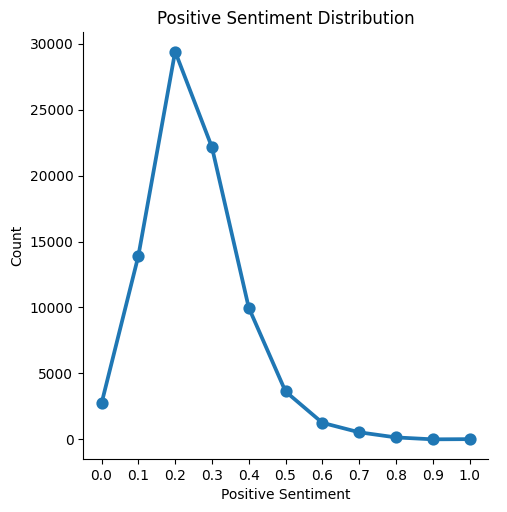

In [54]:
import numpy as np
import numpy as np
bins = np.arange(0, 1.1, 0.1)
import matplotlib.pyplot as plt


# classify the pos column valus  into one of 10 bins in new coliunm pos_bin
reviews_df = reviews_df.withColumn("pos_bin", round((col("pos") / 0.1 ).cast("int") * 0.1,1))
reviews_df.groupby("pos_bin").count().sort("pos_bin").show()
pos_histogram = reviews_df.groupby("pos_bin").count().sort("pos_bin").toPandas()

# Use Seaborn's catplot (formerly factorplot) to create the histogram-like plot
sb.catplot(x="pos_bin", y="count", data=pos_histogram, kind="point", height=5,width=1)
# plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))  # Format y-axis labels

plt.title("Positive Sentiment Distribution")
plt.xlabel("Positive Sentiment")
plt.ylabel("Count")

plt.show()


+-------+-----+
|neg_bin|count|
+-------+-----+
|    0.0|82457|
|    0.1| 1210|
|    0.2|   88|
|    0.3|   21|
|    0.4|    3|
|    0.5|    1|
+-------+-----+



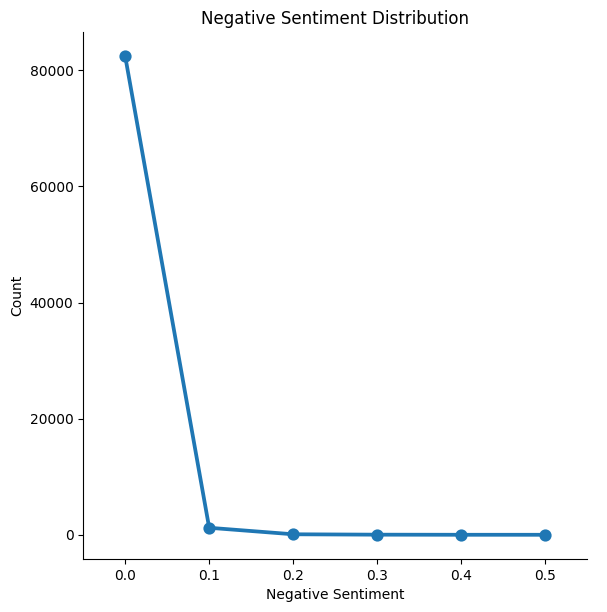

In [53]:
import numpy as np
import numpy as np
bins = np.arange(0, 1.1, 0.1)
import matplotlib.pyplot as plt


# classify the pos column valus  into one of 10 bins in new coliunm pos_bin
reviews_df = reviews_df.withColumn("neg_bin", round((col("neg") / 0.1 ).cast("int") * 0.1,1))
reviews_df.groupby("neg_bin").count().sort("neg_bin").show()
pos_histogram = reviews_df.groupby("neg_bin").count().sort("neg_bin").toPandas()

# Use Seaborn's catplot (formerly factorplot) to create the histogram-like plot
sb.catplot(x="neg_bin", y="count", data=pos_histogram, kind="point", height=6,width=1)
# plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))  # Format y-axis labels

plt.title("Negative Sentiment Distribution")
plt.xlabel("Negative Sentiment")
plt.ylabel("Count")

plt.show()


+-------+-----+
|neu_bin|count|
+-------+-----+
|    0.0|   26|
|    0.1|  151|
|    0.2|  570|
|    0.3| 1312|
|    0.4| 3827|
|    0.5|11043|
|    0.6|24794|
|    0.7|29361|
|    0.8|10967|
|    0.9|  671|
|    1.0| 1058|
+-------+-----+



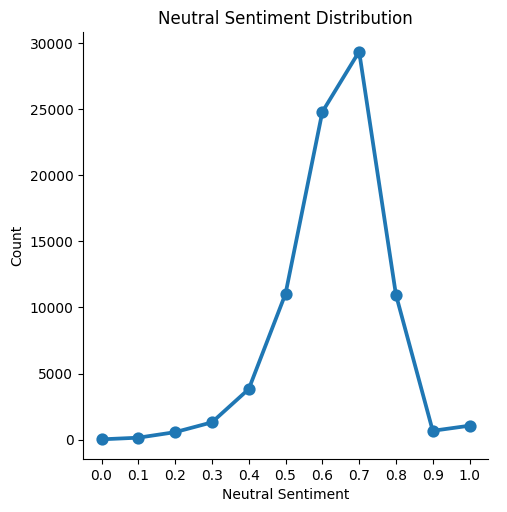

In [52]:
import numpy as np
import numpy as np
bins = np.arange(0, 1.1, 0.1)
import matplotlib.pyplot as plt


# classify the pos column valus  into one of 10 bins in new coliunm pos_bin
reviews_df = reviews_df.withColumn("neu_bin", round((col("neu") / 0.1 ).cast("int") * 0.1,1))
reviews_df.groupby("neu_bin").count().sort("neu_bin").show()
pos_histogram = reviews_df.groupby("neu_bin").count().sort("neu_bin").toPandas()

# Use Seaborn's catplot (formerly factorplot) to create the histogram-like plot
sb.catplot(x="neu_bin", y="count", data=pos_histogram, kind="point", height=5,width=1)
# plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))  # Format y-axis labels

plt.title("Neutral Sentiment Distribution")
plt.xlabel("Neutral Sentiment")
plt.ylabel("Count")

plt.show()


#### Analyzing if number of reviews a listing affects its price.


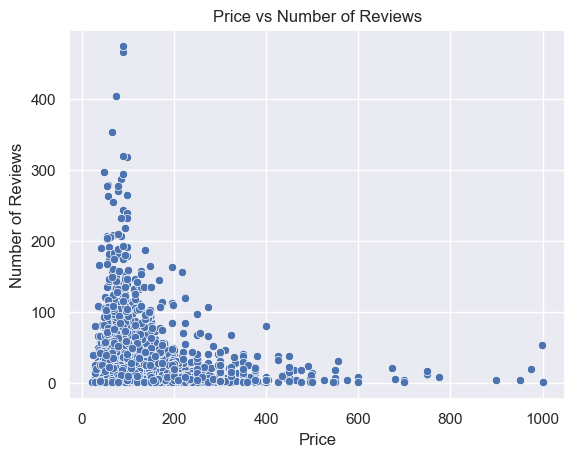

In [59]:
# plot price with number of reviews using seaborn woth grid and gray background
sb.set(style="darkgrid")
price_reviews = df.select("price", "number_of_reviews").toPandas()
sb.scatterplot(x="price", y="number_of_reviews", data=price_reviews)
plt.title("Price vs Number of Reviews")
plt.xlabel("Price")
plt.ylabel("Number of Reviews")
plt.show() 


<Axes: >

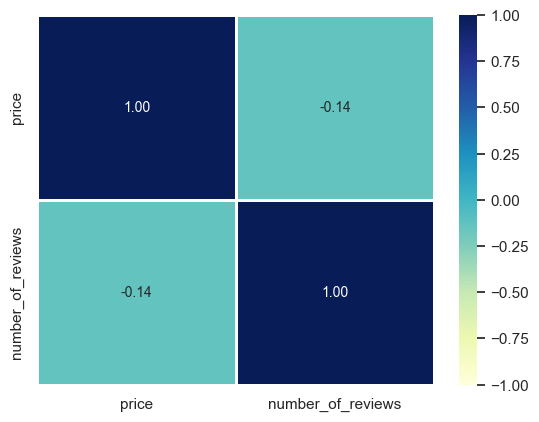

In [66]:
sb.heatmap(price_reviews.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 10}, cmap = "YlGnBu")